# Предсказание оттока клиентов интернет-магазина

Данный проект был реализован по заданию на майноре в НИУ ВШЭ (департамент информатики, Санкт-Петербургская школа физико-математических и компьютерных наук):

Задача -- проанализировать данные оттока и представить результаты в компактной и понятной форме.

### Что нужно:

* выделите подгруппу, которая представляет наибольший интерес, обоснуйте свой выбор
* постройте модель для предсказания оттока (любым методом на ваш выбор, см. первый модуль)
* выявите основные факторы, которые значимы для предсказания оттока согласно этой модели
* протестируйте, как изменится метрика, если удастся повлиять на ключевой фактор. Приведите несколько визуальных примеров

### Формальное:

* это задание на работу с базой данных, вам нужно показать свое умение составлять запросы, вытаскивать в окружение R только часть данных, необходимую для анализа
   + должно быть **не менее трех запросов** с помощью SQL
   + за загрузку сразу всего датасета решения будут штрафоваться, то есть вам нужно вытаскивать только часть данных, а не весь датасет целиком (но без фанатизма -- сохранять результаты запросов этой части данных в датафреймы и делать какой-то продвинутый анализ уже средствами R можно, нет задачи абсолютно все считать с помощью SQL)

#### Подключение к базе данных

In [83]:
import clickhouse_connect

from matplotlib import pyplot as plt 
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

In [84]:
client=clickhouse_connect.get_client(port=8443, host='rc1a-i6ui9dhblsq8rgdo.mdb.yandexcloud.net', user='studentminor', password='DataMinorHSE!2023', 
                             database='ecommerce', verify=False)

#### Анализ

Рассмотрим, какая у нас всего доля оттока среди всех клиентов магазина.

In [2]:
res1=client.query("SELECT COUNT(Churn) FILTER (WHERE Churn=1)/COUNT(Churn) AS total_share FROM useraccount")
res1.result_rows

[(0.16838365896980462,)]

Почти 17%. Однако эта доля может различаться среди разных категорий клиентов. Попробуем посмотреть на конкретное количество ушедших клиентов в зависимости от поставленной магазину оценки.

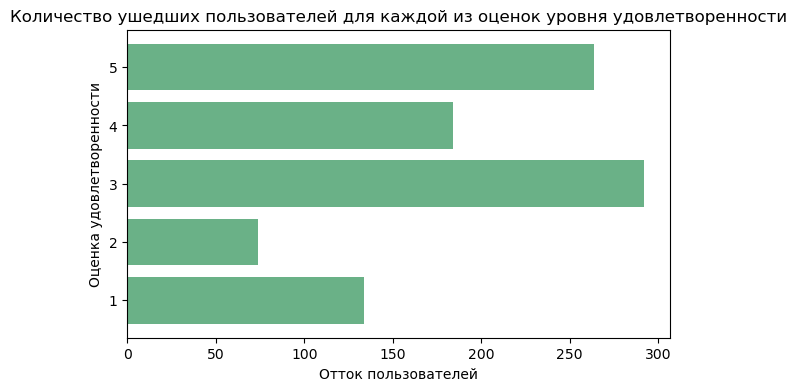

In [3]:
res2=client.query('SELECT SUM(Churn) AS number_of_left, SatisfactionScore FROM useraccount GROUP BY SatisfactionScore ORDER BY number_of_left')
res2=pd.DataFrame(res2.result_rows, columns=['number_of_left', 'SatisfactionScore'])

plt.figure(figsize=(7,4))
plt.barh(res2['SatisfactionScore'], res2['number_of_left'], color='#6AB187')
plt.title('Количество ушедших пользователей для каждой из оценок уровня удовлетворенности')
plt.xlabel('Отток пользователей')
plt.ylabel('Оценка удовлетворенности')
plt.show()

Видно, что абсолютное значение оттока клиентов наибольшее для поставивших оценку 3, однако это может быть вызвано искажением за счёт общего количества клиентов, поставивших такую оценку. Посмотрим на доли оттока по группам:

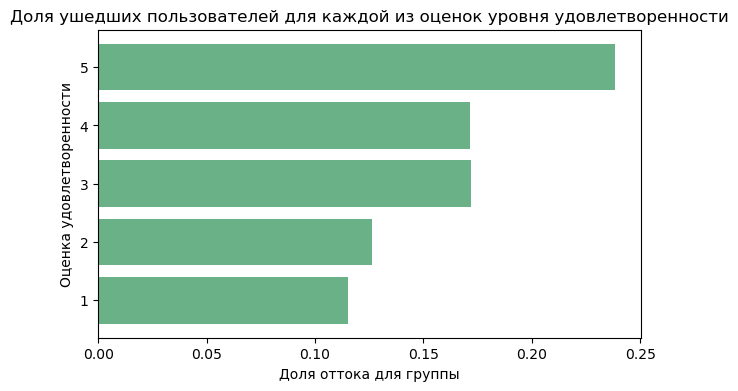

In [4]:
res3=client.query('SELECT SUM(Churn)/COUNT(Churn) AS share_of_left, SatisfactionScore FROM useraccount GROUP BY SatisfactionScore ORDER BY SatisfactionScore')
res3=pd.DataFrame(res3.result_rows, columns=['share_of_left','SatisfactionScore'])

plt.figure(figsize=(7,4))
plt.barh(res3['SatisfactionScore'], res3['share_of_left'], color='#6AB187')
plt.title('Доля ушедших пользователей для каждой из оценок уровня удовлетворенности')
plt.xlabel('Доля оттока для группы')
plt.ylabel('Оценка удовлетворенности')
plt.show()

In [5]:
user_account=client.query('SELECT * FROM useraccount WHERE SatisfactionScore=5').result_rows
user_account=pd.DataFrame(user_account, columns=["CustomerID","Churn","Tenure","PreferredLoginDevice","PreferredPaymentMode","HourSpendOnApp","NumberOfDeviceRegistered","SatisfactionScore","NumberOfAddress","Complain","CouponUsed","OrderCount","DaySinceLastOrder","CashbackAmount","CategoryID"])
user_account = user_account.replace(r'^\s*$', pd.NA, regex=True)
user_account.info(), user_account.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   CustomerID                1108 non-null   int64 
 1   Churn                     1108 non-null   int64 
 2   Tenure                    1062 non-null   object
 3   PreferredLoginDevice      1108 non-null   object
 4   PreferredPaymentMode      1108 non-null   object
 5   HourSpendOnApp            1064 non-null   object
 6   NumberOfDeviceRegistered  1108 non-null   int64 
 7   SatisfactionScore         1108 non-null   int64 
 8   NumberOfAddress           1108 non-null   int64 
 9   Complain                  1108 non-null   int64 
 10  CouponUsed                1061 non-null   object
 11  OrderCount                1056 non-null   object
 12  DaySinceLastOrder         1049 non-null   object
 13  CashbackAmount            1108 non-null   int64 
 14  CategoryID              

(None,
 CustomerID                   0
 Churn                        0
 Tenure                      46
 PreferredLoginDevice         0
 PreferredPaymentMode         0
 HourSpendOnApp              44
 NumberOfDeviceRegistered     0
 SatisfactionScore            0
 NumberOfAddress              0
 Complain                     0
 CouponUsed                  47
 OrderCount                  52
 DaySinceLastOrder           59
 CashbackAmount               0
 CategoryID                   0
 dtype: int64)

Заменим пустые значения в признаках:

In [6]:
user_account['HourSpendOnApp'].fillna(user_account['HourSpendOnApp'].median(), inplace=True)
user_account['OrderCount'].fillna(user_account['OrderCount'].median(), inplace=True)
user_account['DaySinceLastOrder'].fillna(user_account['DaySinceLastOrder'].median(), inplace=True)
user_account['CouponUsed'].fillna(user_account['CouponUsed'].median(), inplace=True)
user_account['Tenure'].fillna(user_account['Tenure'].median(), inplace=True)

Преобразуем типы данных для дальнейшей работы с моделями:

In [7]:
user_account['PreferredLoginDevice'] = user_account['PreferredLoginDevice'].astype('category')
user_account['Tenure'] = user_account['Tenure'].astype(int)
user_account['PreferredPaymentMode'] = user_account['PreferredPaymentMode'].astype('category')
user_account['Complain'] = user_account['Complain'].astype('category')
user_account['CouponUsed'] = user_account['CouponUsed'].astype(int)
user_account['CategoryID'] = user_account['CategoryID'].astype('category')
user_account['DaySinceLastOrder'] = user_account['DaySinceLastOrder'].astype(int)
user_account['HourSpendOnApp'] = user_account['HourSpendOnApp'].astype(int)
user_account['OrderCount'] = user_account['OrderCount'].astype(int)
user_account['Churn'] = user_account['Churn'].astype('category')
user_account=user_account.drop(columns=['CustomerID'])

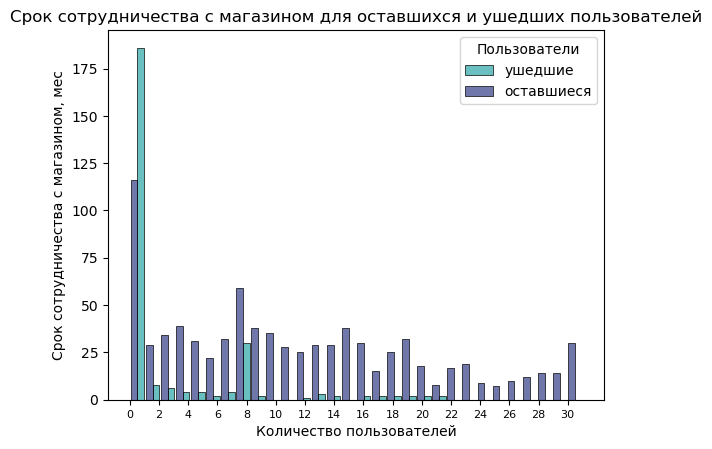

In [8]:
sns.histplot(data=user_account, x='Tenure', hue='Churn', bins=30, palette='mako', multiple='dodge', shrink=0.9)
plt.title('Срок сотрудничества с магазином для оставшихся и ушедших пользователей')
plt.xlabel('Количество пользователей')
plt.ylabel('Срок сотрудничества с магазином, мес')
plt.xticks(range(0, 31, 2), fontsize=8)
plt.legend(title='Пользователи', labels=['ушедшие', 'оставшиеся'])
plt.show()

На графике явно видно, что наибольший отток для клиентов, поставивших оценку 5 сервису - среди пользователей, которые пользовались услугами до 1 месяца. Поскольку это интернет-магазин, логично предположить, что отток по большей мере обеспечивается покупателями, приходящими с целью разовой покупки: их все устраивает в работе магазина, но они не постоянные покупатели.

#### Предсказательные модели

Построим модели бинарной классификации. Обратимся к дереву решений, логистической регрессии, а также посмотрим на разницу в качестве по сравнению с обычным деревом решений при применении ансамблей (градиентный бустинг). В первую очередь преобразуем категориальные переменные через one-hot-encoding c использованием get_dummies. 

In [9]:
user_account_dummies=pd.get_dummies(user_account, columns=['PreferredLoginDevice', 'PreferredPaymentMode', 'CategoryID'], drop_first=False)

Используем подбор оптимальной глубины дерева через крос-валидацию

In [10]:
X=user_account_dummies.drop(columns=['Churn'])
Y=user_account_dummies['Churn']
X_train, X_test, y_train, y_test=train_test_split(X,Y, test_size=0.2, random_state=333)
treemodel=DecisionTreeClassifier(random_state=333)

params={'max_depth':range(1,10)}
gridsearchcv=GridSearchCV(estimator=treemodel, param_grid=params, cv=5, scoring='accuracy')
gridsearchcv=gridsearchcv.fit(X_train, y_train)
print("Лучшие параметры:", gridsearchcv.best_params_)
print("Самая высокая метрика accuracy:", gridsearchcv.best_score_)

Best parameters: {'max_depth': 9}
Best accuracy: 0.9074525487208784


Рассчитаем результаты дерева решений на тестовой выборке: 

In [88]:
treemodel=DecisionTreeClassifier(max_depth=gridsearchcv.best_params_['max_depth'], random_state=333).fit(X_train, y_train)
tree_test_pred=treemodel.predict(X_test)
confusion_matrix_tree=confusion_matrix(y_test, tree_test_pred)
print('Accuracy на тестовой выборке:', accuracy_score(y_test, tree_test_pred))
print('Recall на тестовой выборке:', recall_score(y_test, tree_test_pred))
print('Precision на тестовой выборке:', precision_score(y_test, tree_test_pred))
print('Specificity на тестовой выборке:', (confusion_matrix_tree[0, 0]) / (confusion_matrix_tree[0, 0] + confusion_matrix_tree[0, 1]))
print('Confusion matrix для тестовой выборки:', confusion_matrix_tree)
print('Confusion matrix для обучающей выборки:', confusion_matrix(y_train, treemodel.predict(X_train)))

Accuracy на тестовой выборке: 0.9234234234234234
Recall на тестовой выборке: 0.88
Precision на тестовой выборке: 0.8
Specificity на тестовой выборке: 0.936046511627907
Confusion matrix для тестовой выборки: [[161  11]
 [  6  44]]
Confusion matrix для обучающей выборки: [[662  10]
 [ 24 648]]


In [12]:
print(y_train.value_counts(), y_test.value_counts())

0    672
1    214
Name: Churn, dtype: int64 0    172
1     50
Name: Churn, dtype: int64


Видно по результатам, что specificity имеет более высокий показатель, чем другие переменные. Это может быть обеспечено за счет несбалансированности классов целевой переменной. Посмотрим на результат после балансировки с помощью синтетических значений через SMOTE. Также отскалируем значения для дальнейшего построения логистической регрессии:

In [13]:
smote = SMOTE(random_state=333)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
Xy=pd.concat([X_train_res, y_train_res], axis=1).dropna()
Xy_scaled=StandardScaler().fit_transform(Xy)
X_train=Xy.drop(columns=['Churn'])
y_train=Xy['Churn']

y_train.value_counts()

0    672
1    672
Name: Churn, dtype: int64

In [89]:
treemodel=DecisionTreeClassifier(max_depth=gridsearchcv.best_params_['max_depth'], random_state=333).fit(X_train, y_train)
tree_test_pred=treemodel.predict(X_test)
confusion_matrix_tree=confusion_matrix(y_test, tree_test_pred)
print('Accuracy на тестовой выборке:', accuracy_score(y_test, tree_test_pred))
print('Recall на тестовой выборке:', recall_score(y_test, tree_test_pred))
print('Precision на тестовой выборке:', precision_score(y_test, tree_test_pred))
print('Specificity на тестовой выборке:', (confusion_matrix_tree[0, 0]) / (confusion_matrix_tree[0, 0] + confusion_matrix_tree[0, 1]))
print('Confusion matrix для тестовой выборки:', confusion_matrix_tree)
print('Confusion matrix для обучающей выборки:', confusion_matrix(y_train, treemodel.predict(X_train)))

Accuracy на тестовой выборке: 0.9234234234234234
Recall на тестовой выборке: 0.88
Precision на тестовой выборке: 0.8
Specificity на тестовой выборке: 0.936046511627907
Confusion matrix для тестовой выборки: [[161  11]
 [  6  44]]
Confusion matrix для обучающей выборки: [[662  10]
 [ 24 648]]


Выросли результаты recall после балансировки классов, при этом другие параметры остались примерно на том же уровне, а accuracy модели выросла.

In [15]:
log_reg=LogisticRegression(max_iter=2000).fit(X_train, y_train)
log_reg_test_pred=log_reg.predict(X_test)
confusion_matrix_log=confusion_matrix(y_test, log_reg_test_pred)
print('Accuracy на тестовой выборке:', accuracy_score(y_test, log_reg_test_pred))
print('Recall на тестовой выборке:', recall_score(y_test, log_reg_test_pred))
print('Precision на тестовой выборке:', precision_score(y_test, log_reg_test_pred))
print('Specificity на тестовой выборке:', (confusion_matrix_log[0, 0]) / (confusion_matrix_log[0, 0] + confusion_matrix_log[0, 1]))

Accuracy on test: 0.8468468468468469
Recall on test: 0.8
Precision on test: 0.625
Specificity on test: 0.8604651162790697


Логистическая регрессия дает менее точные результаты предсказаний.

In [33]:
X_train['Complain']=X_train['Complain'].astype('int64')
xgb=XGBClassifier(max_depth=gridsearchcv.best_params_['max_depth']).fit(X_train, y_train)
xgb_test_pred=xgb.predict(X_test)
confusion_matrix_xgb=confusion_matrix(y_test, xgb_test_pred)
print('Accuracy на тестовой выборке:', accuracy_score(y_test, xgb_test_pred))
print('Recall на тестовой выборке:', recall_score(y_test, xgb_test_pred))
print('Precision на тестовой выборке:', precision_score(y_test, xgb_test_pred))
print('Specificity на тестовой выборке:', (confusion_matrix_xgb[0, 0]) / (confusion_matrix_xgb[0, 0] + confusion_matrix_xgb[0, 1]))

Accuracy on test: 0.9819819819819819
Recall on test: 1.0
Precision on test: 0.9259259259259259
Specificity on test: 0.9767441860465116


Модель выглядит переобученной, попробуем регуляризировать модель:

In [72]:
xgb=XGBClassifier(max_depth=5, n_estimators=80, learning_rate=0.1, reg_lambda=1).fit(X_train, y_train)
xgb_test_pred=xgb.predict(X_test)
confusion_matrix_xgb=confusion_matrix(y_test, xgb_test_pred)
print('Accuracy на тестовой выборке:', accuracy_score(y_test, xgb_test_pred))
print('Recall на тестовой выборке:', recall_score(y_test, xgb_test_pred))
print('Precision на тестовой выборке:', precision_score(y_test, xgb_test_pred))
print('Specificity на тестовой выборке:', (confusion_matrix_xgb[0, 0]) / (confusion_matrix_xgb[0, 0] + confusion_matrix_xgb[0, 1]))

Accuracy on test: 0.9594594594594594
Recall on test: 0.94
Precision on test: 0.8867924528301887
Specificity on test: 0.9651162790697675


Рассчитаем наиболее важные переменные для модели градиентного бустинга, которую до этого построили:

In [79]:
importance=pd.DataFrame(xgb.feature_importances_)
features=pd.DataFrame(X_train.columns)
feat_imp=pd.concat([importance, features], axis=1)
#feat_imp.sort_values(by=)
feat_imp.columns=['Importance', 'Features']
feat_imp.sort_values(by='Importance', ascending=False)

,Importance,Features
0,0.164116,Tenure
18,0.081220,CategoryID_1
20,0.063698,CategoryID_3
21,0.062005,CategoryID_4
9,0.055736,CashbackAmount
4,0.051597,NumberOfAddress
14,0.046967,PreferredPaymentMode_Credit Card
10,0.045737,PreferredLoginDevice_Computer
11,0.045177,PreferredLoginDevice_Mobile Phone
8,0.044230,DaySinceLastOrder


Наиболее важная переменная - срок взаимодействия с интернет-магазином, как было показано ранее на одном из графиков. Еще раз построим визуализацию, только в этот раз уберем месяцы с нулевым оттоком и покажем только саму долю оттока


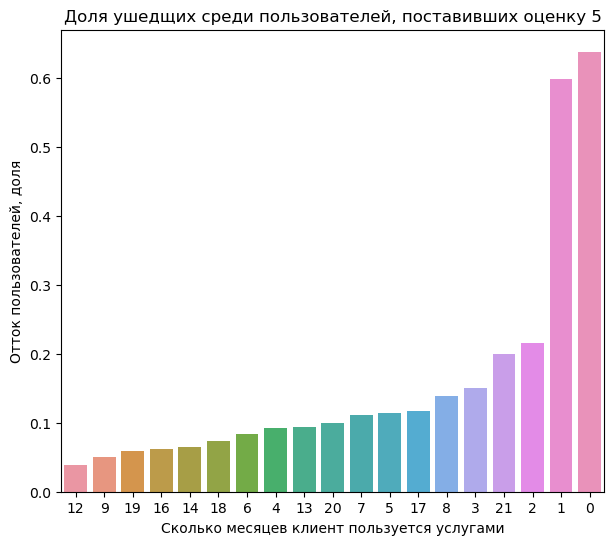

In [81]:
res4=client.query('SELECT SUM(Churn)/COUNT(Churn) as share_of_left, Tenure FROM useraccount WHERE SatisfactionScore=5 GROUP BY Tenure ORDER BY share_of_left DESC')
res4=pd.DataFrame(res4.result_rows, columns=['share_of_left', 'Tenure'])
res4=res4[res4['Tenure']!=''].sort_values(by='share_of_left')
res4=res4[res4['share_of_left']!=0]

plt.figure(figsize=(7,6))
sns.barplot(x=res4['Tenure'], y=res4['share_of_left'])
plt.title('Доля ушедщих среди пользователей, поставивших оценку 5')
plt.xlabel('Сколько месяцев клиент пользуется услугами')
plt.ylabel('Отток пользователей, доля')
plt.show()

#### Симуляция

Продемонстрируем визуально, как изменился бы прогноз по оттоку при удержании каждого из новых пользователей еще на 3 месяца

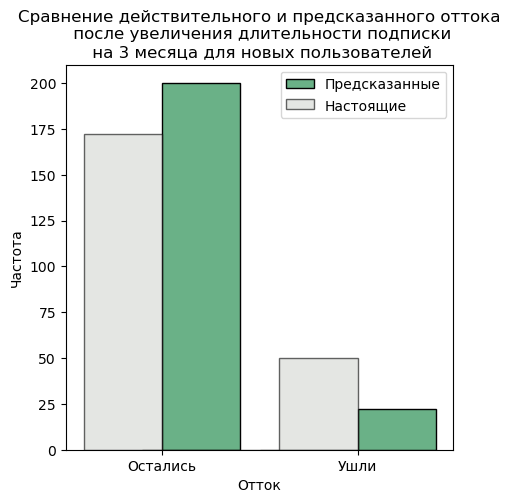

In [82]:
X_test_simulator=X_test.copy()
X_test_simulator.loc[X_test_simulator['Tenure']<=1, 'Tenure']+=3

plt.figure(figsize=(5,5))
plt.hist(xgb.predict(X_test_simulator), color='#6AB187', edgecolor='black', label='Предсказанные', align='right', bins=[-0.2, 0.2, 0.8, 1.2])
plt.hist(y_test, color='#D2D6D1', label='Настоящие', edgecolor='black' ,alpha=0.6, align='left', bins=[-0.2, 0.2, 0.8, 1.2])
plt.title('Сравнение действительного и предсказанного оттока\n после увеличения длительности подписки\n на 3 месяца для новых пользователей')
plt.xlabel('Отток')
plt.ylabel('Частота')
plt.xticks(range(0,2), ['Остались', 'Ушли'] )
plt.legend()
plt.show()

#### Общие выводы

Среди всех клиентов, поставивших магазину оценки, наиболее высокий уровень оттока у тех, кто поставил максимальную оценку "5". Был сделан вывод, что это, скорее всего, связано с тем, что эти клиенты изначально приходят ради одной покупки, поэтому их уход связан не с недовольством предоставляемым сервером. 

Были рассмотрены такие модели как дерево решений, логистическая регрессия, использован бустинг. Чтобы модели не компенсировали accuracy за счет specificity и делали точные предсказания не только на обучающих выборках, обучающая выборка была сбалансирована. Наилучшие показатели оказались у модели, построенной при помощи бустинга. 

Наиболее значимой переенной оказался срок взаимодействия клиента с магазином, поэтому в качестве переменной, на основе которой проводились симуляции, была выбрана tenure.